In [1]:
!pip install lmdb tqdm gdown faiss-cpu Pillow torch kornia kornia_moons psycopg2

     |████████████████████████████████| 8.6 MB 5.5 MB/s 
     |████████████████████████████████| 493 kB 42.8 MB/s 


In [2]:
!pip install opencv-python -U

     |████████████████████████████████| 60.5 MB 1.4 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
!pip install lmdb -U

     |████████████████████████████████| 298 kB 5.4 MB/s 
  Attempting uninstall: lmdb
    Found existing installation: lmdb 0.99
    Uninstalling lmdb-0.99:
      Successfully uninstalled lmdb-0.99


In [4]:
# install
!apt install postgresql postgresql-contrib &>log
!service postgresql start
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD '12345';"

 * Starting PostgreSQL 10 database server
   ...done.
ALTER ROLE


In [5]:
!gdown --id 15OA8TMkAsEQ2fa0dCv59-mdGGBSE-KIJ

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=15OA8TMkAsEQ2fa0dCv59-mdGGBSE-KIJ
To: /content/archive_scenery.zip
100% 650M/650M [00:03<00:00, 201MB/s]


In [6]:
%%time
import zipfile
zip_ref = zipfile.ZipFile("archive_scenery.zip", 'r')
zip_ref.extractall("./scenery")
zip_ref.close()

CPU times: user 5.05 s, sys: 1.96 s, total: 7.01 s
Wall time: 9.13 s


convert filenames to sequential ids

In [7]:
import os
n = 1
FILE_PATH="./scenery/"
from tqdm import tqdm
file_names = os.listdir(FILE_PATH)
file_names.sort()
for file_name in tqdm(file_names):
    oldext = os.path.splitext(file_name)[1]
    os.rename(FILE_PATH+file_name, FILE_PATH + str(n) + oldext)
    n += 1

100%|██████████| 4319/4319 [00:00<00:00, 14276.25it/s]


calculate local features, store in lmdb

In [8]:
import cv2
import torch
from os import listdir
import math
import lmdb
from tqdm import tqdm
import numpy as np
import kornia as K
import kornia.feature as KF
from kornia_moons import feature
laf_from_opencv_SIFT_kpts = feature.laf_from_opencv_SIFT_kpts

detector = cv2.SIFT_create(nfeatures=200)
device = "cuda" if torch.cuda.is_available() else "cpu"
HardNet8 = KF.HardNet8(True).eval().to(device)

import psycopg2
import psycopg2.extras


def prepare_db():
    conn = psycopg2.connect("dbname=postgres host=localhost user=postgres password=12345")
    cur = conn.cursor()
    cur.execute("SELECT 1 FROM pg_catalog.pg_database WHERE datname = 'ambience'")
    exists = cur.fetchone()
    conn.commit()
    if not exists:
        conn.autocommit = True
        cur.execute('CREATE DATABASE ambience')
        conn = psycopg2.connect("dbname=ambience host=localhost user=postgres password=12345")
        cur = conn.cursor()
        cur.execute("""CREATE TABLE IF NOT EXISTS img_points (
            image_id integer NOT NULL UNIQUE,
            point_id_range int4range NOT NULL)""")
        cur.execute('CREATE INDEX point_id_range_gist_index ON img_points USING GIST (point_id_range);')
        conn.commit()
        return conn
    else:
        conn = psycopg2.connect("dbname=ambience host=localhost user=postgres password=12345")
        return conn

DB_img_points = prepare_db()
DB_keypoints = lmdb.open('./keypoints.lmdb',map_size=150*1_000_000 * 1000) #500gb
DB_descriptors = lmdb.open('./descriptors.lmdb',map_size=150*1_000_000 * 1000) #500gb


def check_if_exists_by_id(id):
    cur = DB_img_points.cursor()
    cur.execute("select exists(select 1 from img_points where image_id=%s)",[id])
    result = cur.fetchone()
    return result[0]

def resize_img_to_threshold(img):
    height, width = img.shape
    threshold = 3000*3000
    if height*width > threshold:
        k = math.sqrt(height*width/(threshold))
        img = cv2.resize(img, (round(width/k), round(height/k)), interpolation=cv2.INTER_LINEAR)
    return img

def get_features(img):
    kpts = detector.detect(img, None)
    if len(kpts) == 0:
        return None
    with torch.no_grad():
            timg = K.image_to_tensor(img, False).float()/255.
            timg = timg.to(device)
            lafs = laf_from_opencv_SIFT_kpts(kpts, device=device)
            patches = KF.extract_patches_from_pyramid(timg, lafs, 32)
            B, N, CH, H, W = patches.size()
            descs = HardNet8(patches.view(B * N, CH, H, W)).view(B * N, -1).detach().cpu().numpy()   
    return kpts, descs


def calc_features(file_name):
    try:
        file_id=int(file_name[:file_name.index('.')])
        img_path=IMAGE_PATH+"/"+file_name
        query_image=cv2.imread(img_path,0)
        if query_image is None:
            print(f"can't read {file_name}")
            return None
        img_keypoints_decscs = get_features(query_image)
        if img_keypoints_decscs is None:
            return None    
        kpts,descs = img_keypoints_decscs
        # print(file_name)
        return (file_id,kpts,descs)
    except:
        print(f"error in {file_name}")
        return None

def int_to_bytes(x: int) -> bytes:
    return x.to_bytes((x.bit_length() + 7) // 8, 'big')


IMAGE_PATH="./scenery"
file_names=listdir(IMAGE_PATH)
print(f"images in {IMAGE_PATH} = {len(file_names)}")
new_images=[]

for file_name in tqdm(file_names):
    file_id=int(file_name[:file_name.index('.')])
    if check_if_exists_by_id(file_id):
        continue
    new_images.append(file_name)

print(f"new images = {len(new_images)}")
new_images=[new_images[i:i + 10000] for i in range(0, len(new_images), 10000)]

LAST_POINT_ID = 1
for batch in new_images:
    data=[calc_features(file_name) for file_name in tqdm(batch)]
    data= [i for i in data if i] #remove None's
    print("pushing data to db")
    img_points_data = []
    keypoints_data = []
    descriptors_data = []
    for el in data:
        img_points_data.append( (el[0],f'[{LAST_POINT_ID},{LAST_POINT_ID + len(el[1])}]') ) # image_id point_id_start poind_id_end
        _point_id = LAST_POINT_ID
        for keypoint,descriptor in zip(el[1],el[2]):
            _point_id_bytes = int_to_bytes(_point_id)
            descriptors_data.append( (_point_id_bytes, descriptor.tobytes()) )
            keypoints_data.append( (_point_id_bytes, np.float32([keypoint.pt[0], keypoint.pt[1]]).tobytes()) )
            _point_id+=1

        LAST_POINT_ID+=len(el[1])+1
    
    cur = DB_img_points.cursor()
    insert_query = "INSERT INTO img_points (image_id, point_id_range) VALUES %s"
    psycopg2.extras.execute_values(cur, insert_query, img_points_data, template=None, page_size=100)
    DB_img_points.commit()

    with DB_keypoints.begin(write=True, buffers=True) as txn:
        with txn.cursor() as curs:
            curs.putmulti(keypoints_data)

    with DB_descriptors.begin(write=True, buffers=True) as txn:
        with txn.cursor() as curs:
            curs.putmulti(descriptors_data)

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/hardnet8v2.pt" to /root/.cache/torch/hub/checkpoints/hardnet8v2.pt


  0%|          | 0.00/34.5M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


images in ./scenery = 4319


100%|██████████| 4319/4319 [00:01<00:00, 3319.59it/s]


new images = 4319


100%|██████████| 4319/4319 [25:57<00:00,  2.77it/s]


pushing data to db


Train index

In [9]:
from tqdm import tqdm
import numpy as np
import lmdb
import math
import faiss
dim = 128
# DB_descriptors = lmdb.open("descriptors.lmdb", readonly=True)
nlist = int(math.sqrt(DB_descriptors.stat()["entries"]))
print(f"entries = {DB_descriptors.stat()['entries']}")
print(f"nlist = {nlist}")
index = faiss.index_factory(dim,f"OPQ64,IVF{nlist},PQ64",faiss.METRIC_L2)
batch_size=DB_descriptors.stat()['entries'] #50_000_000

features = np.memmap('train.mmap', dtype='float32', mode='w+', shape=(batch_size, dim))
def get_data():
    with DB_descriptors.begin(buffers=True) as txn:
        with txn.cursor() as curs:
            retrieved = 0
            for data in tqdm(curs.iternext(keys=False, values=True),total=batch_size):
                if retrieved == batch_size:
                    return
                features[retrieved] = np.frombuffer(data,dtype=np.float32)
                retrieved+=1
get_data()

print("Training......")
from timeit import default_timer as timer
start = timer()
index.train(features)
end = timer()
print(end - start)
faiss.write_index(index,"./trained.index")

entries = 851652
nlist = 922


100%|██████████| 851652/851652 [00:06<00:00, 131667.72it/s]


Training......
1522.580400791


Add to index

In [10]:
from tqdm import tqdm
import numpy as np
import lmdb
import faiss
dim = 128
# DB_descriptors = lmdb.open("descriptors.lmdb", readonly=True)
index = faiss.read_index("./trained.index")

def int_from_bytes(xbytes: bytes) -> int:
    return int.from_bytes(xbytes, 'big')

def get_all_data_iterator(batch_size=1000000):
    with DB_descriptors.begin(buffers=True) as txn:
        with txn.cursor() as curs:
            temp_ids = np.zeros(batch_size,np.int64)
            temp_descriptors = np.zeros((batch_size,dim),np.float32)
            retrieved = 0
            for data in curs.iternext(keys=True, values=True):
                temp_ids[retrieved] = int_from_bytes(data[0])
                temp_descriptors[retrieved] = np.frombuffer(data[1],dtype=np.float32)
                retrieved+=1
                if retrieved == batch_size:
                    retrieved=0
                    yield temp_ids, temp_descriptors
            if retrieved != 0:
                yield temp_ids[:retrieved], temp_descriptors[:retrieved]

for ids, descriptors in tqdm(get_all_data_iterator(1000000)):
    index.add_with_ids(descriptors,ids)
faiss.write_index(index,"./populated.index")

1it [00:57, 57.70s/it]


Search

In [11]:
def get_point_ids(image_id):
    cursor = DB_img_points.cursor()
    cursor.execute("SELECT point_id_range FROM img_points WHERE image_id = %s",[image_id])
    result = cursor.fetchone()
    if result is None:
        return []
    else:
        return list(range(result[0].lower,result[0].upper))

In [12]:
import requests
r = requests.get("https://i.imgur.com/JF1Yx3i.jpeg")
with open("./test_img.jpg", "wb") as f:
    f.write(r.content)

In [13]:
query_image=cv2.imread("./test_img.jpg",0)
orig_kpts, orig_descs = get_features(query_image)

In [14]:
orig_kpts = np.float32([x.pt for x in orig_kpts]).reshape(-1,2)

In [15]:
def get_image_id_by_point_id(point_id):
    cursor = DB_img_points.cursor()
    cursor.execute("SELECT image_id FROM img_points WHERE point_id_range @> %s",[point_id])
    result = cursor.fetchone()
    if result is None:
        return None
    else:
        return result[0]
k_clusters = 5
matching_threshold = 0.9
min_matches = 4
D, I = index.search(orig_descs, k_clusters)
D = D.flatten()
I = I.flatten()
search_res={}
for i in range(len(I)):
    if D[i] < matching_threshold:
        point_id = int(I[i])
        image_id = get_image_id_by_point_id(point_id)
        if image_id in search_res:
            search_res[image_id] +=1
        else:
            search_res[image_id] = 1
res=[{"image_id":img_id, "matches":matches} for img_id,matches in sorted(search_res.items(), key=lambda item: item[1],reverse=True) if matches>=min_matches]

In [16]:
print(res)

[{'image_id': 1491, 'matches': 48}, {'image_id': 1256, 'matches': 5}, {'image_id': 4096, 'matches': 5}, {'image_id': 2693, 'matches': 4}, {'image_id': 1479, 'matches': 4}]


In [17]:
def get_kpts_and_descs_by_id(image_id):
    point_ids = get_point_ids(image_id)
    point_ids = [int_to_bytes(x) for x in point_ids]
    kpts=np.zeros( (len(point_ids), 2), dtype=np.float32 )
    descs=np.zeros( (len(point_ids), dim), dtype=np.float32 )
    with DB_keypoints.begin(buffers=True) as txn:
        with txn.cursor() as curs:
            _kpts = curs.getmulti(point_ids)
            for i in range(len(_kpts)):
                kpts[i]=np.frombuffer(_kpts[i][1], dtype=np.float32)
    with DB_descriptors.begin(buffers=True) as txn:
        with txn.cursor() as curs:
            _descs = curs.getmulti(point_ids)
            for i in range(len(_descs)):
                descs[i]=np.frombuffer(_descs[i][1], dtype=np.float32)
    return kpts, descs

In [18]:
!pip install pydegensac

     |████████████████████████████████| 2.4 MB 5.2 MB/s 


In [19]:
import pydegensac
def verify_pydegensac(src_pts,dst_pts,th = 4,  n_iter = 5000):
    _, mask = pydegensac.findHomography(src_pts, dst_pts, th, 0.999, n_iter)
    return mask

In [20]:
new_res = []
for item in res:
  kpts, descs = get_kpts_and_descs_by_id(item["image_id"])
  match_threshold = 0.8
  dists, match_ids = KF.match_snn(torch.from_numpy(orig_descs), torch.from_numpy(descs),match_threshold)
  if len(dists) > 3:
    mask = verify_pydegensac(orig_kpts[match_ids[:,0]],kpts[match_ids[:,1]])
    
    new_res.append({"image_id":item["image_id"],"matches":int(mask.sum())})
new_res = sorted(new_res, key=lambda item: item["matches"], reverse=True)

In [21]:
print(new_res)

[{'image_id': 1491, 'matches': 50}]


In [22]:
from PIL import Image
images_np=[]
for item in new_res:
  image_id = item["image_id"]
  images_np.append(np.array(Image.open(f'{IMAGE_PATH}/{image_id}.jpg')))

In [23]:
import matplotlib.pyplot as plt
def show_images(images, figsize=(20,10), columns = 5):
  plt.figure(figsize=figsize)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.imshow(image)

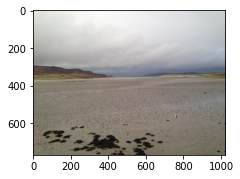

In [24]:
show_images(images_np)

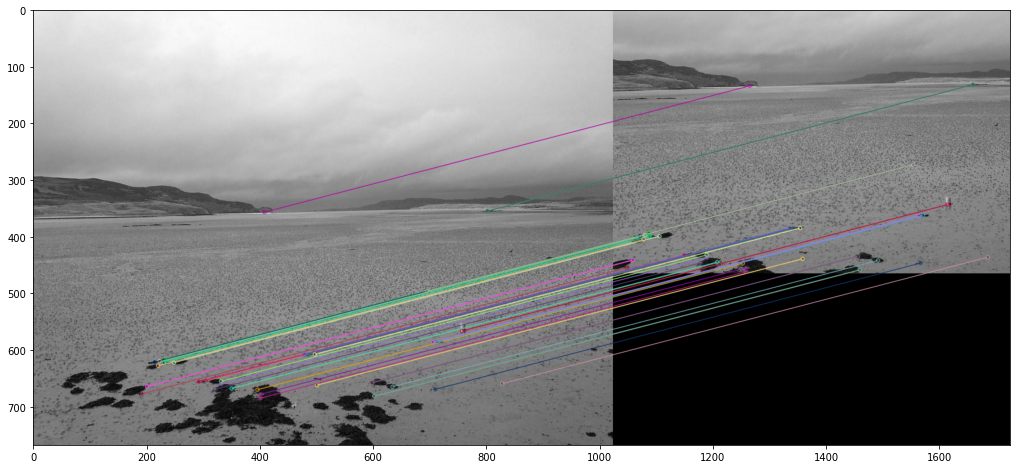

In [25]:
query_image1=cv2.imread("./scenery/1491.jpg",0)
kpts1_orig, descs1 = get_features(query_image1)
kpts1 = np.float32([x.pt for x in kpts1_orig]).reshape(-1,2)

query_image2=cv2.imread("./test_img.jpg",0)
kpts2_orig, descs2 = get_features(query_image2)
kpts2 = np.float32([x.pt for x in kpts2_orig]).reshape(-1,2)


match_threshold = 0.8
dists, match_ids = KF.match_snn(torch.from_numpy(descs1), torch.from_numpy(descs2),match_threshold)
match_ids=match_ids.numpy()
match_ids=np.array(match_ids)

mask = verify_pydegensac(kpts1[match_ids[:,0]],kpts2[match_ids[:,1]])
mask = [int(x) for x in mask]
good_matches = [cv2.DMatch(x[0], x[1],1) for x in match_ids]

img3 = cv2.drawMatches(query_image1,kpts1_orig,query_image2,kpts2_orig,good_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,matchesMask=mask) 
plt.figure(figsize = (80,8))

plt.imshow(img3)
plt.show()